# Sommaire :

<a href="#A5">**Part 5 : Supervized image classification with data augmentation**</a>

# Préparation du dataset

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import random
import shutil
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, adjusted_rand_score
from glob import glob
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2023-03-28 16:58:14.408196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 16:58:15.262227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-28 16:58:15.262313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object f

In [2]:
# Load dtatbase
df = pd.read_csv('df.csv')

2023-03-28 16:58:16.143102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pds5): /proc/driver/nvidia/version does not exist


In [3]:
# Chemin vers le dossier contenant toutes les images
data_dir = 'Images/'

# Proportion des images à utiliser pour l'ensemble de test
test_ratio = 0.2

# 'Créer' les dossiers pour le training set et test set
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [4]:
# Création d'un training dataset et d'un test dataset
from sklearn import preprocessing

path = train_dir
path_test = test_dir

# Liste des classes
list_labels = ['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers']
label_no_name = "no_name "

# Fonction d'affection de l'étiquette à la photo correspondante
def photo_class(photo) :
    for label in list_labels :
        print('photo : ',str(photo)[-36:])
        img = str(photo)[-36:]
        if label in df.loc[(df['image'].isin([img]) == True), 'class_'] :  
            return label
    return label_no_name
    
data_path = glob(path+'*/*.jp*')
data_test_path = glob(path_test+'*/*.jp*')

# Création d'un dataframe qui colonne photo et étiquette
def data_fct(path) :
    list_photos = [file for file in path]
    print(len(list_photos))
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["label_name"] = data["image_path"].apply(lambda x : photo_class(x))
    return data

# Filtre train et test
f_tr = os.listdir(train_dir)
f_te = os.listdir(test_dir)

# Appliquer le filtre à df
data = df.loc[df['image'].isin(f_tr),['image','class_']].reset_index(drop=True)
data_test = df.loc[df['image'].isin(f_te),['image','class_']].reset_index(drop=True)

# Renommer les colonnes
data.rename(columns = {'class_':'label_name', 'image':'image_path'}, inplace = True)
data_test.rename(columns = {'class_':'label_name', 'image':'image_path'}, inplace = True)

# Encodage de l'étiquette
le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])
data_test["label"] = le.transform(data_test["label_name"])
# data.head(5)
data_test.head(5)

,image_path,label_name,label
0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Watches,6
1,62c35de4df27437d3597963fac55a8b6.jpg,Watches,6
2,7c4fec2331da8d40f2cb146eb198cb57.jpg,Watches,6
3,ee8d9ff65e0fe4278afce7c933d30941.jpg,Watches,6
4,b85f8843bb1c297dd5712f0bd287006d.jpg,Home Furnishing,4


# classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [5]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

## Approche préparation initiale des images

In [6]:
%%time
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        try :
            img = (load_img(train_dir + '/' +
            data['image_path'][image_num],
            target_size=(224, 224)))
        except :
            img = (load_img(test_dir + '/' +
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(833, 224, 224, 3)
(215, 224, 224, 3)
CPU times: user 2min 5s, sys: 39.4 s, total: 2min 44s
Wall time: 3min 55s


In [7]:
# Définition des X et y pour le training et validation et des X_test et y_test pour le test
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

In [8]:
# Partage des X et y en train et validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(624, 224, 224, 3)

In [9]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

2023-03-28 17:02:25.281784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Recherche du plus grand diviseur de X_test
num = X_test.shape[0]
for i in range(2, num):
    if i < 40:
        if num % i == 0:
            diviseur = i
    else :
        continue

print("Le plus grand diviseur de X_test < 40 de", num, "est", diviseur)

Le plus grand diviseur de X_test < 40 de 215 est 5


In [11]:
# Entraîner sur les données d'entraînement (X_train, y_train) epochs=5 au lieu de 50
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=2, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 6.0851 - accuracy: 0.4295
Epoch 1: val_loss improved from inf to 1.42461, saving model to ./model1_best_weights.h5
10/10 [==============================] - 59s 6s/step - loss: 6.0851 - accuracy: 0.4295 - val_loss: 1.4246 - val_accuracy: 0.6986
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 2.3593 - accuracy: 0.6667
Epoch 2: val_loss improved from 1.42461 to 1.36231, saving model to ./model1_best_weights.h5
10/10 [==============================] - 58s 6s/step - loss: 2.3593 - accuracy: 0.6667 - val_loss: 1.3623 - val_accuracy: 0.7464


In [12]:
# Score du dernier epoch
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 43s 2s/step - loss: 0.8048 - accuracy: 0.8462
Training Accuracy: 0.8462

7/7 [==============================] - 14s 2s/step - loss: 1.3623 - accuracy: 0.7464
Validation Accuracy:  0.7464


In [13]:
# Score de l'epoch optimal
model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7464
Test Accuracy       :  0.7535


In [14]:
pip install plot-keras-history

Note: you may need to restart the kernel to use updated packages.


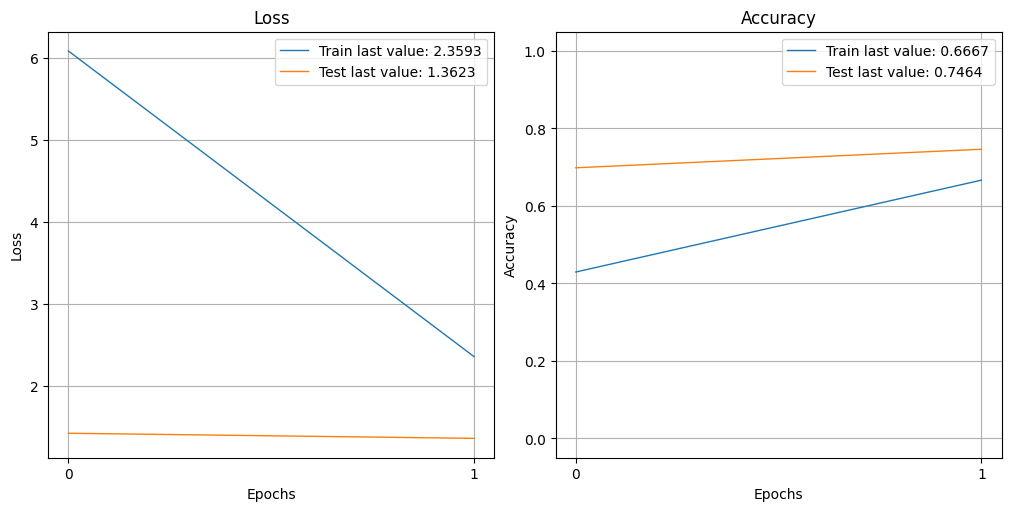

In [15]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [16]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 15s 2s/step
[5 4 2 5 2 6 6 2 3 6 0 4 3 5 2 0 6 0 4 3 3 6 3 3 6 2 3 6 2 0 0 2 5 0 0 6 5
 3 6 4 4 5 1 4 5 1 2 3 2 4 4 1 6 6 2 5 2 3 6 4 0 0 3 3 5 2 0 1 6 4 4 2 4 0
 5 0 2 5 4 2 1 1 3 5 4 3 5 4 6 3 3 1 3 4 5 1 6 0 1 4 0 3 5 2 2 6 1 4 5 5 3
 2 6 3 6 1 4 5 2 1 6 6 1 1 2 3 5 4 5 3 4 3 3 5 1 0 4 4 0 5 4 1 6 1 1 4 1 2
 4 0 2 4 1 5 2 4 1 0 2 4 0 0 2 6 4 2 4 3 0 0 6 3 0 4 6 5 0 2 3 1 6 0 6 1 5
 0 5 2 0 1 6 1 2 1 3 6 3 6 5 0 0 1 1 5 2 3 5 0 3]

[5 4 2 5 5 6 2 6 3 6 0 4 3 5 2 0 6 4 4 2 3 6 3 3 6 2 3 6 5 4 0 2 5 1 0 6 5
 5 6 4 4 5 1 4 5 1 0 3 2 4 4 1 6 6 4 5 5 3 6 4 3 1 3 6 5 2 3 3 6 4 4 5 4 4
 5 0 3 5 4 2 1 1 3 5 4 3 5 3 6 3 2 1 5 4 6 1 6 3 1 4 0 3 5 2 5 6 1 4 5 5 1
 2 6 3 6 1 4 1 2 1 6 6 1 1 1 5 5 4 5 3 4 6 1 5 2 4 4 4 5 5 4 1 6 1 1 4 1 5
 4 0 2 4 2 5 2 4 5 4 3 4 4 0 4 6 4 3 4 3 0 4 6 4 0 4 6 5 4 5 3 1 6 0 6 1 5
 4 5 2 0 1 6 1 2 2 4 2 3 6 5 0 0 1 1 5 2 5 5 0 4]


In [17]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[15  2  0  3  9  1  0]
 [ 0 23  3  1  0  1  0]
 [ 1  1 15  3  2  7  1]
 [ 0  2  2 18  3  4  2]
 [ 0  0  0  1 31  0  0]
 [ 0  1  0  0  0 27  1]
 [ 0  0  2  0  0  0 27]]


In [18]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    
    print ("Correspondance des clusters : ", corresp)
    
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

[[15  2  0  3  9  1  0]
 [ 0 23  3  1  0  1  0]
 [ 1  1 15  3  2  7  1]
 [ 0  2  2 18  3  4  2]
 [ 0  0  0  1 31  0  0]
 [ 0  1  0  0  0 27  1]
 [ 0  0  2  0  0  0 27]]
Correspondance des clusters :  [0 1 2 3 4 5 6]
[[15  2  0  3  9  1  0]
 [ 0 23  3  1  0  1  0]
 [ 1  1 15  3  2  7  1]
 [ 0  2  2 18  3  4  2]
 [ 0  0  0  1 31  0  0]
 [ 0  1  0  0  0 27  1]
 [ 0  0  2  0  0  0 27]]

              precision    recall  f1-score   support

           0       0.94      0.50      0.65        30
           1       0.79      0.82      0.81        28
           2       0.68      0.50      0.58        30
           3       0.69      0.58      0.63        31
           4       0.69      0.97      0.81        32
           5       0.68      0.93      0.78        29
           6       0.87      0.93      0.90        29

    accuracy                           0.75       209
   macro avg       0.76      0.75      0.74       209
weighted avg       0.76      0.75      0.73       209



<Axes: >

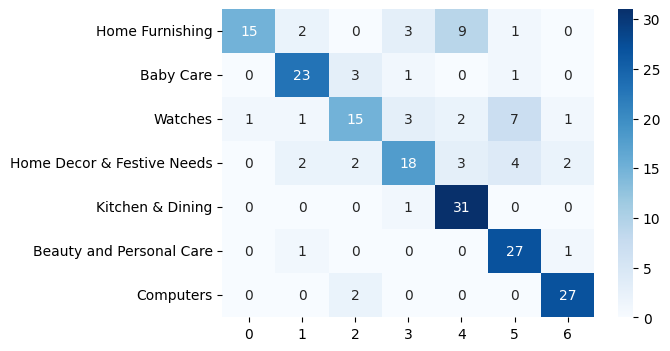

In [19]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)

conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [20]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [23]:
# préview training data
data

,image_path,label_name,label
0,c705a5735a94aeee547d1798e3e46ec4.jpg,Watches,6
1,7815fb39feb773db944c9f03bbdcbf64.jpg,Computers,2
2,1eda39f01d0a8a2e5ce4b32fc7da1027.jpg,Computers,2
3,11f06dffebf7edf9e15351834a190c2c.jpg,Baby Care,0
4,ce02ab514e4c623dcf7acd7182a7762d.jpg,Kitchen & Dining,5
...,...,...,...
828,d1e18b4a3aafb0040da2111c8b8ce2e5.jpg,Home Decor & Festive Needs,3
829,0d3e1dc0d38be59e9927e47f152e48aa.jpg,Kitchen & Dining,5
830,833a87b0af3b84fe246d2ebf271af177.jpg,Computers,2
831,97fba8a02361aa56eaa9fa51bc1d7661.jpg,Watches,6


In [24]:
%%time
images_features = []
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(train_dir +'/'+ image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600
700
800
CPU times: user 5min, sys: 3.3 s, total: 5min 3s
Wall time: 3min 4s


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(833, 4096)

In [25]:
def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory=dir_, #train_dir+'/',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [26]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

batch_size = 32
dir_ = train_dir+'/'
train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

batch_size = diviseur
dir_ = test_dir+'/'
test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 625 validated image filenames belonging to 7 classes.
Found 208 validated image filenames belonging to 7 classes.
Found 215 validated image filenames belonging to 7 classes.


In [27]:
# Preview de la database de test
data_test

,image_path,label_name,label
0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Watches,6
1,62c35de4df27437d3597963fac55a8b6.jpg,Watches,6
2,7c4fec2331da8d40f2cb146eb198cb57.jpg,Watches,6
3,ee8d9ff65e0fe4278afce7c933d30941.jpg,Watches,6
4,b85f8843bb1c297dd5712f0bd287006d.jpg,Home Furnishing,4
...,...,...,...
210,2651ce313a5a3aedb7c566394a3b3b26.jpg,Beauty and Personal Care,1
211,29def171d7e31d48571a52f0fb3e6b07.jpg,Home Decor & Festive Needs,3
212,5a54c78b52c984e56500809e5bc27ae1.jpg,Computers,2
213,678ebb5f6057dcc51948253c1b39b0b8.jpg,Home Furnishing,4


In [28]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [30]:
batch_size = 32
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=2, callbacks=callbacks_list, verbose=1)


Epoch 1/2
20/20 [==============================] - ETA: 0s - loss: 4.2018 - accuracy: 0.4752
Epoch 1: val_loss improved from inf to 1.48844, saving model to ./model2_best_weights.h5
20/20 [==============================] - 86s 4s/step - loss: 4.2018 - accuracy: 0.4752 - val_loss: 1.4884 - val_accuracy: 0.7115
Epoch 2/2
20/20 [==============================] - ETA: 0s - loss: 1.6544 - accuracy: 0.6848
Epoch 2: val_loss improved from 1.48844 to 1.22751, saving model to ./model2_best_weights.h5
20/20 [==============================] - 85s 4s/step - loss: 1.6544 - accuracy: 0.6848 - val_loss: 1.2275 - val_accuracy: 0.7404


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [31]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 71s 4s/step - loss: 0.6161 - accuracy: 0.8448
Training Accuracy   : 0.8448

7/7 [==============================] - 21s 3s/step - loss: 1.1644 - accuracy: 0.7500
Validation Accuracy :  0.7500


In [32]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7500
Test Accuracy       :  0.7721


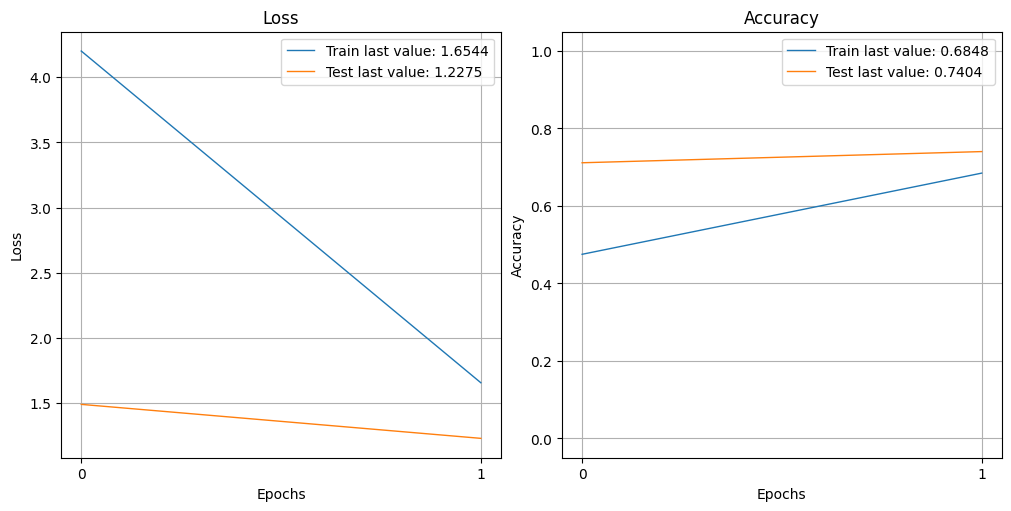

In [33]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [34]:
import os
import shutil

# Le chemin vers le dossier d'entraînement
train_dir = 'train-copy/'

# La table de correspondance entre le nom de l'image et son étiquette
data_train_dic = data.set_index('image_path')['label_name'].to_dict()

# Boucle à travers chaque image dans le dossier de formation
for filename in os.listdir(train_dir):
    # Si l'élément de la boucle est un fichier image
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Trouver l'étiquette associée à l'image en utilisant la table de correspondance
        label_name = data_train_dic.get(filename)
        # Si l'étiquette existe dans la table de correspondance
        if label_name is not None:
            # Créer un nouveau dossier pour l'étiquette s'il n'existe pas déjà
            print(label_name)
            label_dir = os.path.join(train_dir, label_name)
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)
                print(label_dir)
            # Déplacer l'image dans le sous-dossier de l'étiquette
            src_path = os.path.join(train_dir, filename)
            dst_path = os.path.join(label_dir, filename)
            shutil.move(src_path, dst_path)

In [35]:
import os
import shutil

# Le chemin vers le dossier d'entraînement
test_dir = 'test-copy/'

# La table de correspondance entre le nom de l'image et son étiquette
data_test_dic = data_test.set_index('image_path')['label_name'].to_dict()

# Boucle à travers chaque image dans le dossier de formation
for filename in os.listdir(test_dir):
    # Si l'élément de la boucle est un fichier image
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Trouver l'étiquette associée à l'image en utilisant la table de correspondance
        label_name = data_test_dic.get(filename)
        # Si l'étiquette existe dans la table de correspondance
        if label_name is not None:
            # Créer un nouveau dossier pour l'étiquette s'il n'existe pas déjà
            print(label_name)
            label_dir = os.path.join(test_dir, label_name)
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)
                print(label_dir)
            # Déplacer l'image dans le sous-dossier de l'étiquette
            src_path = os.path.join(test_dir, filename)
            dst_path = os.path.join(label_dir, filename)
            shutil.move(src_path, dst_path)

In [36]:
def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical', #'inferred'
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [37]:
batch_size = 32
dataset_train = dataset_fct('train-copy', validation_split=0.25, data_type='training')
dataset_val = dataset_fct('train-copy', validation_split=0.25, data_type='validation')

batch_size = diviseur
dataset_test = dataset_fct('test-copy', validation_split=0, data_type=None)

Found 833 files belonging to 7 classes.
Using 625 files for training.
Found 833 files belonging to 7 classes.
Using 208 files for validation.
Found 215 files belonging to 7 classes.


In [38]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [39]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [40]:
batch_size = 32
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=2, callbacks=callbacks_list, verbose=1)


Epoch 1/2
20/20 [==============================] - ETA: 0s - loss: 6.2167 - accuracy: 0.4896
Epoch 1: val_loss improved from inf to 1.78407, saving model to ./model3_best_weights.h5
20/20 [==============================] - 70s 3s/step - loss: 6.2167 - accuracy: 0.4896 - val_loss: 1.7841 - val_accuracy: 0.7308
Epoch 2/2
20/20 [==============================] - ETA: 0s - loss: 2.3740 - accuracy: 0.6864
Epoch 2: val_loss improved from 1.78407 to 1.53845, saving model to ./model3_best_weights.h5
20/20 [==============================] - 76s 4s/step - loss: 2.3740 - accuracy: 0.6864 - val_loss: 1.5384 - val_accuracy: 0.7548


In [41]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 73s 3s/step - loss: 0.6371 - accuracy: 0.8752
Training Accuracy   : 0.8752

7/7 [==============================] - 35s 5s/step - loss: 1.5384 - accuracy: 0.7548
Validation Accuracy :  0.7548


In [42]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7548
Test Accuracy       :  0.7628


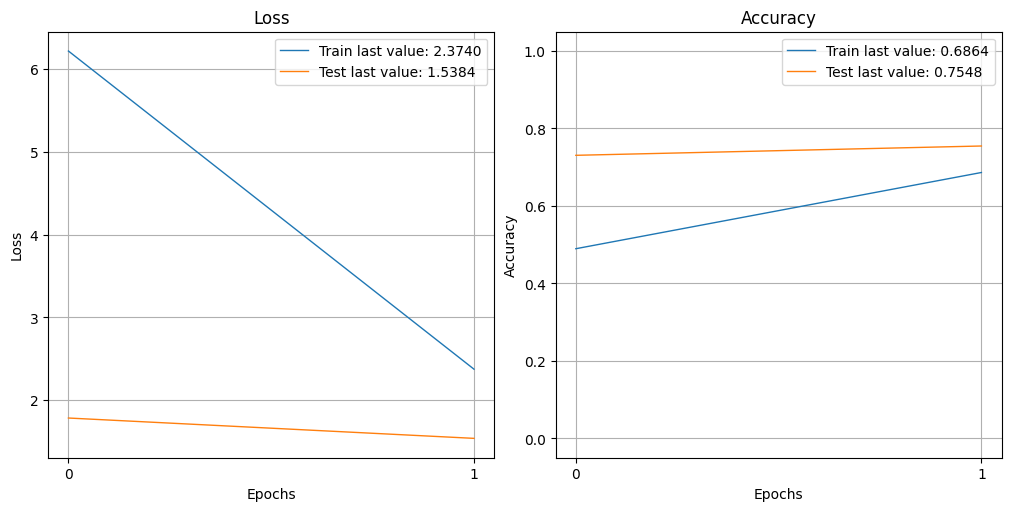

In [43]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [44]:
def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [45]:
batch_size = 32
dataset_train = dataset_fct('train-copy', validation_split=0.25, data_type='training')
dataset_val = dataset_fct('train-copy', validation_split=0.25, data_type='validation')

batch_size = diviseur
dataset_test = dataset_fct('test-copy', validation_split=0, data_type=None)

Found 833 files belonging to 7 classes.
Using 625 files for training.
Found 833 files belonging to 7 classes.
Using 208 files for validation.
Found 215 files belonging to 7 classes.


In [47]:
data_set = dataset_fct('dataset', validation_split=0, data_type=None)

Found 1050 files belonging to 1 classes.


In [48]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [49]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')#4
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [50]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [51]:
model4_save_path = "./model4_best_weights.h5"

In [52]:
# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [53]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [54]:
%%time
batch_size = 32
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=20, callbacks=callbacks_list, verbose=1)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 1.8304 - accuracy: 0.2816
Epoch 1: val_loss improved from inf to 1.44964, saving model to ./model4_best_weights.h5
20/20 [==============================] - 82s 4s/step - loss: 1.8304 - accuracy: 0.2816 - val_loss: 1.4496 - val_accuracy: 0.5433
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 1.3982 - accuracy: 0.5104
Epoch 2: val_loss improved from 1.44964 to 1.14045, saving model to ./model4_best_weights.h5
20/20 [==============================] - 76s 4s/step - loss: 1.3982 - accuracy: 0.5104 - val_loss: 1.1404 - val_accuracy: 0.7260
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.1351 - accuracy: 0.6592
Epoch 3: val_loss im

In [56]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 49s 2s/step - loss: 0.2107 - accuracy: 0.9360
Training Accuracy   : 0.9360

7/7 [==============================] - 18s 2s/step - loss: 0.5211 - accuracy: 0.7981
Validation Accuracy :  0.7981


In [57]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8077
Test Accuracy       :  0.8186


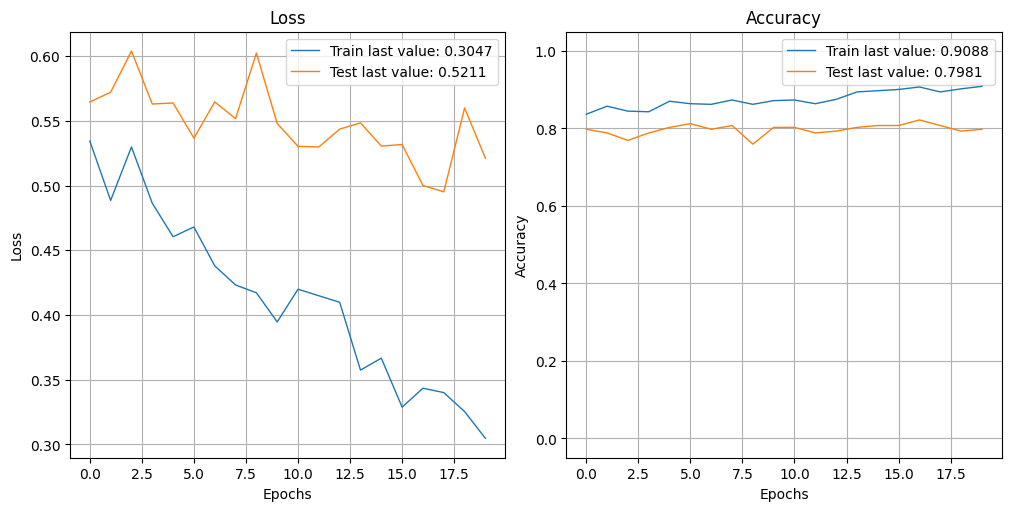

In [58]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

In [59]:
y_test_num = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model4.predict(X_test), axis=1)
print(y_test_num)
print()
print(y_test_pred)

7/7 [==============================] - 15s 2s/step
[6 6 6 6 4 3 5 2 5 1 2 1 5 5 5 4 0 0 0 3 3 1 1 0 5 0 0 1 1 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 3 5 3 3 5 3 3 3 3 5 3 5 5 3 5 3 5 3 5 3 3 5 3 0 0 0 3 3 1 1
 2 2 2 2 2 1 2 1 1 1 2 1 2 1 1 1 1 2 1 1 1 1 1 2 2 0 0 4 5 5 0 1 5 1 1 2 2
 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 1 1 4 3 0 1 0 0 2 0 0 4
 0 4 0 0 0 0 3 4 1 1 4 4 4 0 0 4 0 1 2 1 6 6 6 6 1 6 0 6 6 1 1 1 4 1 2 2 2
 2 2 2 2 2 2 4 4 3 6 4 3 4 4 4 1 4 3 4 4 3 0 0 5 5 1 3 2 4 0]

[6 6 6 6 3 1 5 2 5 5 2 1 5 1 3 4 4 0 4 3 3 4 4 0 5 0 0 2 3 5 5 5 5 5 5 5 5
 5 5 5 3 5 5 5 3 6 5 3 5 6 3 3 3 5 3 5 5 3 5 3 5 3 5 3 3 5 3 4 0 0 2 3 1 1
 2 2 2 2 2 1 2 1 1 1 2 3 2 1 1 1 1 4 1 1 1 1 3 2 2 0 0 4 5 5 0 3 5 1 1 2 2
 2 2 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 4 2 3 3 0 3 0 0 2 0 4 4
 3 4 0 3 0 0 3 4 1 2 4 4 4 0 2 4 0 0 1 1 6 1 6 6 1 6 4 6 6 1 1 1 4 1 2 2 2
 2 2 2 2 2 2 4 4 3 3 4 3 4 4 0 1 4 2 0 4 3 4 0 5 5 1 2 2 4 3]


In [60]:
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred)
print(conf_mat)
y_test_pred_transform = conf_mat_transform(y_test_num, y_test_pred)

[[20  0  1  3  6  0  0]
 [ 1 26  3  5  3  1  0]
 [ 0  1 27  0  1  0  0]
 [ 0  1  3 20  0  1  1]
 [ 2  0  0  2 18  0  0]
 [ 0  1  0  2  0 31  1]
 [ 0  1  1  1  0  0 31]]
Correspondance des clusters :  [0 1 2 3 4 5 6]


In [61]:
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_test_num, y_test_pred_transform))

[[20  0  1  3  6  0  0]
 [ 1 26  3  5  3  1  0]
 [ 0  1 27  0  1  0  0]
 [ 0  1  3 20  0  1  1]
 [ 2  0  0  2 18  0  0]
 [ 0  1  0  2  0 31  1]
 [ 0  1  1  1  0  0 31]]

              precision    recall  f1-score   support

           0       0.87      0.67      0.75        30
           1       0.87      0.67      0.75        39
           2       0.77      0.93      0.84        29
           3       0.61      0.77      0.68        26
           4       0.64      0.82      0.72        22
           5       0.94      0.89      0.91        35
           6       0.94      0.91      0.93        34

    accuracy                           0.80       215
   macro avg       0.81      0.81      0.80       215
weighted avg       0.82      0.80      0.81       215



<Axes: >

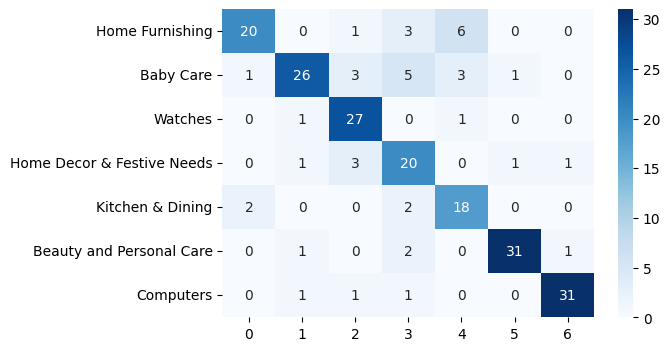

In [62]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [63]:
adjusted_rand_score(y_test_num, y_test_pred_transform)

0.6112106212369955

In [64]:
# On applique le modèle optimal sur tout le dataser pour évaluer le processing time

In [65]:
X = np.concatenate((X,X_test))
y = np.concatenate((y, y_test))

In [66]:
t1 = time.time()
y_pred = model4.predict(X)
t_va = time.time() - t1

33/33 [==============================] - 72s 2s/step


In [72]:
t_va

72.34646916389465

In [67]:
y_num = np.argmax(y, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [68]:
conf_mat = metrics.confusion_matrix(y_num, y_pred)
print(conf_mat)
y_pred_transform = conf_mat_transform(y_num, y_pred)

[[107   3   3  13  21   1   1]
 [  2 116  11  10   8   2   1]
 [  1   2 137   5   3   1   1]
 [  0   2   4 137   4   1   1]
 [ 10   0   1   8 131   0   0]
 [  2   1   7   6   0 132   2]
 [  0   1   1   2   0   0 146]]
Correspondance des clusters :  [0 1 2 3 4 5 6]


In [69]:
conf_mat = metrics.confusion_matrix(y_num, y_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_num, y_pred_transform))

[[107   3   3  13  21   1   1]
 [  2 116  11  10   8   2   1]
 [  1   2 137   5   3   1   1]
 [  0   2   4 137   4   1   1]
 [ 10   0   1   8 131   0   0]
 [  2   1   7   6   0 132   2]
 [  0   1   1   2   0   0 146]]

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       149
           1       0.93      0.77      0.84       150
           2       0.84      0.91      0.87       150
           3       0.76      0.92      0.83       149
           4       0.78      0.87      0.83       150
           5       0.96      0.88      0.92       150
           6       0.96      0.97      0.97       150

    accuracy                           0.86      1048
   macro avg       0.87      0.86      0.86      1048
weighted avg       0.87      0.86      0.86      1048



<Axes: >

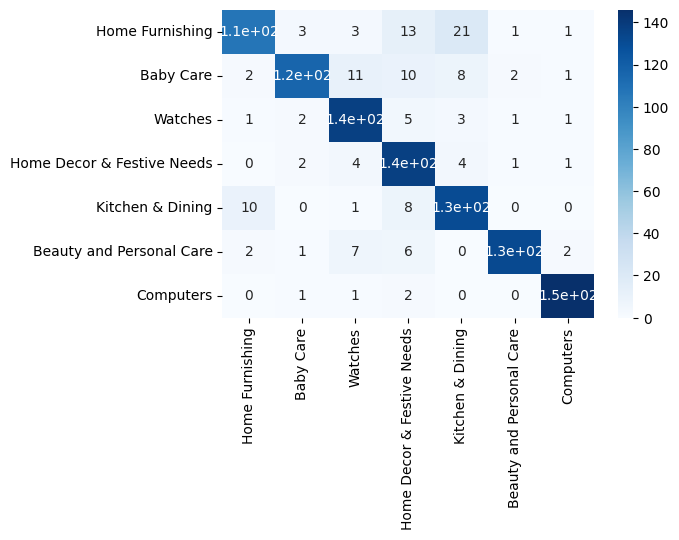

In [70]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in list_labels])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [71]:
adjusted_rand_score(y_num, y_pred_transform)

0.7121433187267562